# MOrdReD: Ordinal autoregression with recurrent neural networks

### Introduction

This Python library accompanies our [work](https://arxiv.org/abs/1803.09704). MOrdReD enables time series forecasting in an autoregressive and ordinal fashion. This simply means two things: that a new sample $x_{t+1}$ is forecasted by looking at previous observations $x_t, x_{t-1}..., x_{t-p}$ for some lookback $p$. 

Our framework provides an implementation of our ordinal autoregression framework (via Keras) described in the paper above; however, it also provides a flexible and amicable interface to set up time series forecasting tasks (parameter optimisation, model selection, model evaluation, long-term prediction, plotting) with either our prediction framework, or other well-established techniques, such as Gaussian Processes (via GPy) or Dynamic AR models (via statsmodels).

The following notebook takes us through the most basic example: loading and preparing a time series dataset, choosing a model, and evaluating it.

In [5]:
%matplotlib inline

from ordinal_tsf.dataset import *
from ordinal_tsf.model import *
from ordinal_tsf.session import *
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="3"

plt.style.use('seaborn-ticks')
matplotlib.rcParams['figure.figsize'] = (20.0, 16.0)
matplotlib.rcParams['font.serif'] = 'times'
labelsize = 26
titlesize=32
params= { 
    'text.usetex':True, "font.family": "serif", "font.serif": ["Computer Modern"],
    'font.family':'serif', 'font.serif': ["Times", "Times New Roman"],
    'legend.fontsize':labelsize, 'axes.labelsize':labelsize, 'axes.titlesize':titlesize, 
    'xtick.labelsize' :labelsize, 'ytick.labelsize' : labelsize
}
matplotlib.rcParams.update(params)

## Starting a session

All interactions with this library are managed by a Session object. This guarantees that other objects such as preprocessed datasets, models, predictions and plots are kept in an orderly way. This also makes sure the project's structure is cohererent and queryable by different modules.

In practice, Sessions are meant to group experiments on the same time series, regardless of whether they are ordinal or real-valued. The id provided as a constructor argument is the name of the folder that will store all of the session's objects.

For this introductory example, we will work with the Mackey Glass chaotic system.

Opening session: mg/...


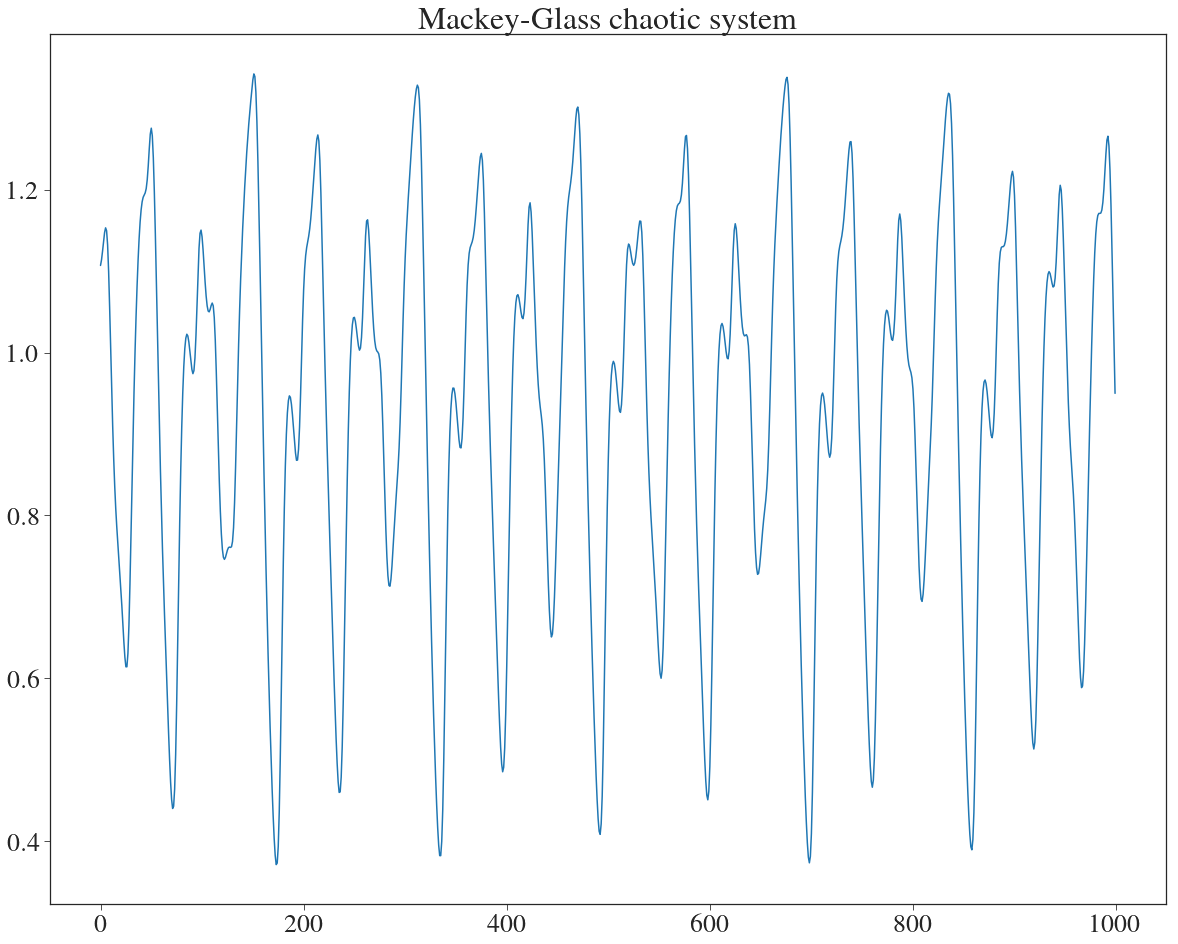

In [9]:
sess = Session('mg')
x = pd.read_feather('mg.feather').values
plt.plot(x[:1000])
plt.title('Mackey-Glass chaotic system')
plt.show()

## Preparing the dataset

All Ordinal TSF models work with the (autoregressive) Dataset interface. This provides a transparent way of framing a time series, as well as applying preprocessing transformations such as: standardising, adding white noise, quantising (binning/discretising), etc. Users can also add any additional data preprocessing steps they may need by providing an object whose class inherits from DatasetPreprocessingStep, as defined in the .dataset package.

For this example, we will only make the time series zero-mean, unit-variance and quantise it in 85 equally-distributed bins over the time series' range. The first 70% of the time series' samples will then be used as the training set for our model, and the validation and test sets are made by equally splitting the remaining 30%.

In [10]:
lookback = 101
horizon = 100
ordinal_bins = 85

stand = Standardiser()
quant = Quantiser(ordinal_bins)

dataset = Dataset(x, lookback + horizon, p_val=0.15, p_test=0.15, preprocessing_steps=[stand, quant])

print "Time series framed into {} training frames with {} {}-feature observations at each timestep\n".format(*dataset.train_frames.shape)

print dataset

Time series framed into 14559 training frames with 201 85-feature observations at each timestep

Dataset with properties:
zero_mean_unit_var:True
bin_delta:0.0494988267428
ts_std:0.234664381011
bins:[-2.37251619 -2.32301736 -2.27351853 -2.22401971 -2.17452088 -2.12502205
 -2.07552323 -2.0260244  -1.97652557 -1.92702675 -1.87752792 -1.82802909
 -1.77853027 -1.72903144 -1.67953261 -1.63003379 -1.58053496 -1.53103613
 -1.48153731 -1.43203848 -1.38253965 -1.33304082 -1.283542   -1.23404317
 -1.18454434 -1.13504552 -1.08554669 -1.03604786 -0.98654904 -0.93705021
 -0.88755138 -0.83805256 -0.78855373 -0.7390549  -0.68955608 -0.64005725
 -0.59055842 -0.5410596  -0.49156077 -0.44206194 -0.39256312 -0.34306429
 -0.29356546 -0.24406664 -0.19456781 -0.14506898 -0.09557016 -0.04607133
  0.0034275   0.05292632  0.10242515  0.15192398  0.2014228   0.25092163
  0.30042046  0.34991928  0.39941811  0.44891694  0.49841576  0.54791459
  0.59741342  0.64691224  0.69641107  0.7459099   0.79540873  0.8449075

## Starting an experiment



In [11]:
experiment = sess.start_experiment(dataset, MordredStrategy)

## Model creation and fitting

Our library offers seamless integration with many Machine Learning libraries (Keras, Tensorflow, GPy, Scikit-Learn) to perform autoregressive (ordinal or real-valued) time series forecasting. This is achieved via the Strategy wrapper, and custom ML models can be added to the library straightforwardly by implementing this interface. 

In this example, we setup an autoregressive ordinal neural network. This is a sequence-to-sequence architecture assembled by the wrapper using Keras layers. Any additional arguments to be passed on to the Keras fit method should be given via a dictionary.


In [26]:
model = MordredStrategy(ordinal_bins=ordinal_bins, units=75)

train_args = {'epochs':50, 'batch_size':256, 'validation_split':0.15}

model.fit(dataset.train_frames, **train_args)

Train on 12375 samples, validate on 2184 samples
Epoch 1/50
 - 28s - loss: 4.0586 - categorical_crossentropy: 4.0586 - val_loss: 3.5398 - val_categorical_crossentropy: 3.5398
Epoch 2/50
 - 24s - loss: 3.2945 - categorical_crossentropy: 3.2945 - val_loss: 2.8961 - val_categorical_crossentropy: 2.8961
Epoch 3/50
 - 23s - loss: 2.8636 - categorical_crossentropy: 2.8636 - val_loss: 2.5298 - val_categorical_crossentropy: 2.5298
Epoch 4/50
 - 24s - loss: 2.5622 - categorical_crossentropy: 2.5621 - val_loss: 2.2609 - val_categorical_crossentropy: 2.2609
Epoch 5/50
 - 24s - loss: 2.3339 - categorical_crossentropy: 2.3339 - val_loss: 2.0545 - val_categorical_crossentropy: 2.0545
Epoch 6/50
 - 24s - loss: 2.1436 - categorical_crossentropy: 2.1436 - val_loss: 1.8708 - val_categorical_crossentropy: 1.8708
Epoch 7/50
 - 24s - loss: 2.0407 - categorical_crossentropy: 2.0407 - val_loss: 1.7532 - val_categorical_crossentropy: 1.7532
Epoch 8/50
 - 24s - loss: 1.8775 - categorical_crossentropy: 1.8775 -

## Forecasting

All model strategies must implement the predict method, but the return object will be different, depending on the dataset's representation (is it real-valued or ordinal? is it mono- or multi-channel?)

The session's 

In [27]:
first_prediction_index = 121
seed_start = first_prediction_index - model.seed_length
validation_predictive_horizon = 300
val_seed = dataset.val_ts[np.newaxis, seed_start:first_prediction_index]
model_output = model.predict(val_seed, predictive_horizon=validation_predictive_horizon, mc_samples=20)
prediction = experiment.build_prediction(model_output)

## Test design

In [28]:
selector = Selector(first_prediction_index, validation_predictive_horizon)
continuous_ground_truth = dataset.apply_partial_preprocessing('val', [selector, stand])
ordinal_ground_truth = dataset.apply_partial_preprocessing('val', [selector, stand, quant])

validation_tests = [TestDefinition('mse', continuous_ground_truth),
                    TestDefinition('nll', ordinal_ground_truth),
                    TestDefinition('cum_nll', ordinal_ground_truth)]

validation_plots = {'plot_median_2std': {'ground_truth':continuous_ground_truth},
                    'plot_cum_nll': {'binned_ground_truth': ordinal_ground_truth},
                    'plot_like': {}}

## Prediction analysis

MSE: 0.198050307877 +- 0.0262471117184
NLL: 29.2952095558


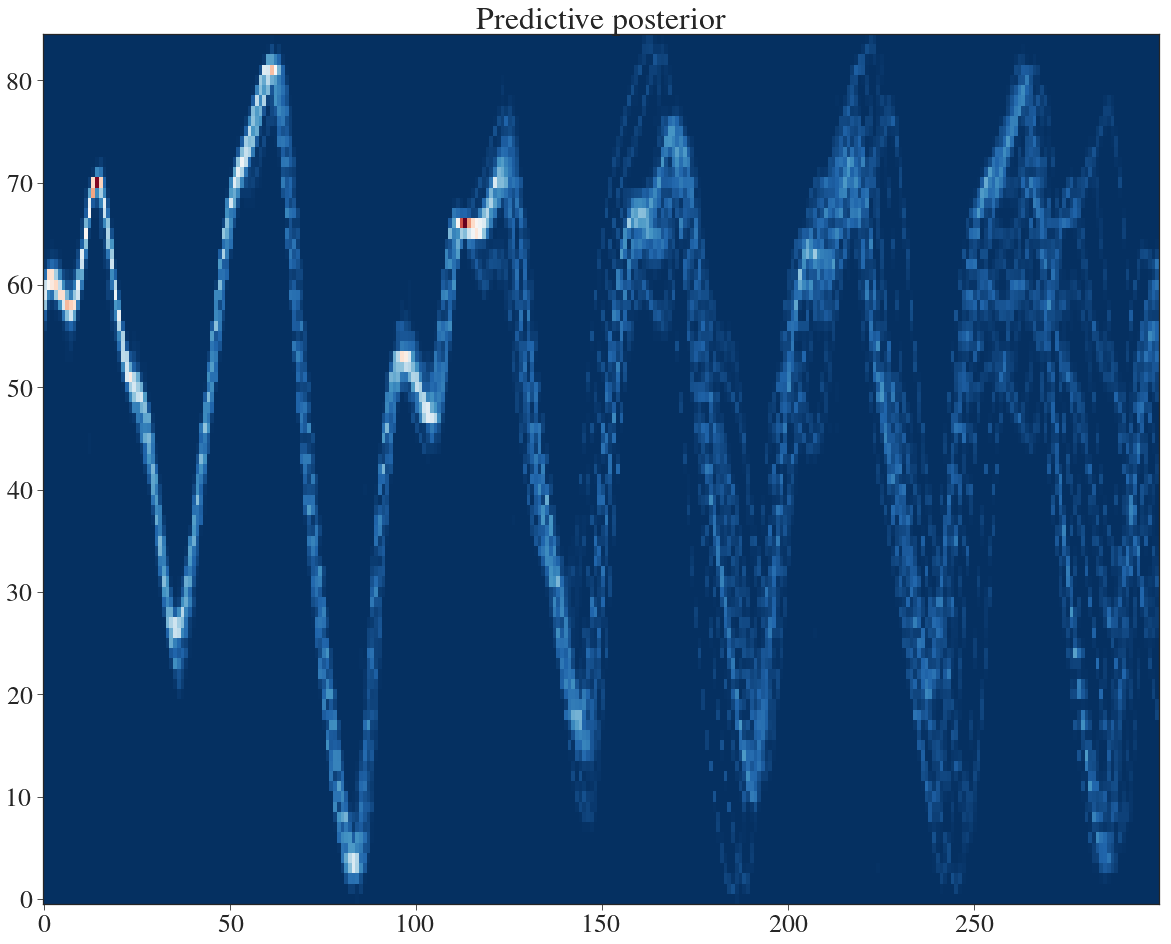

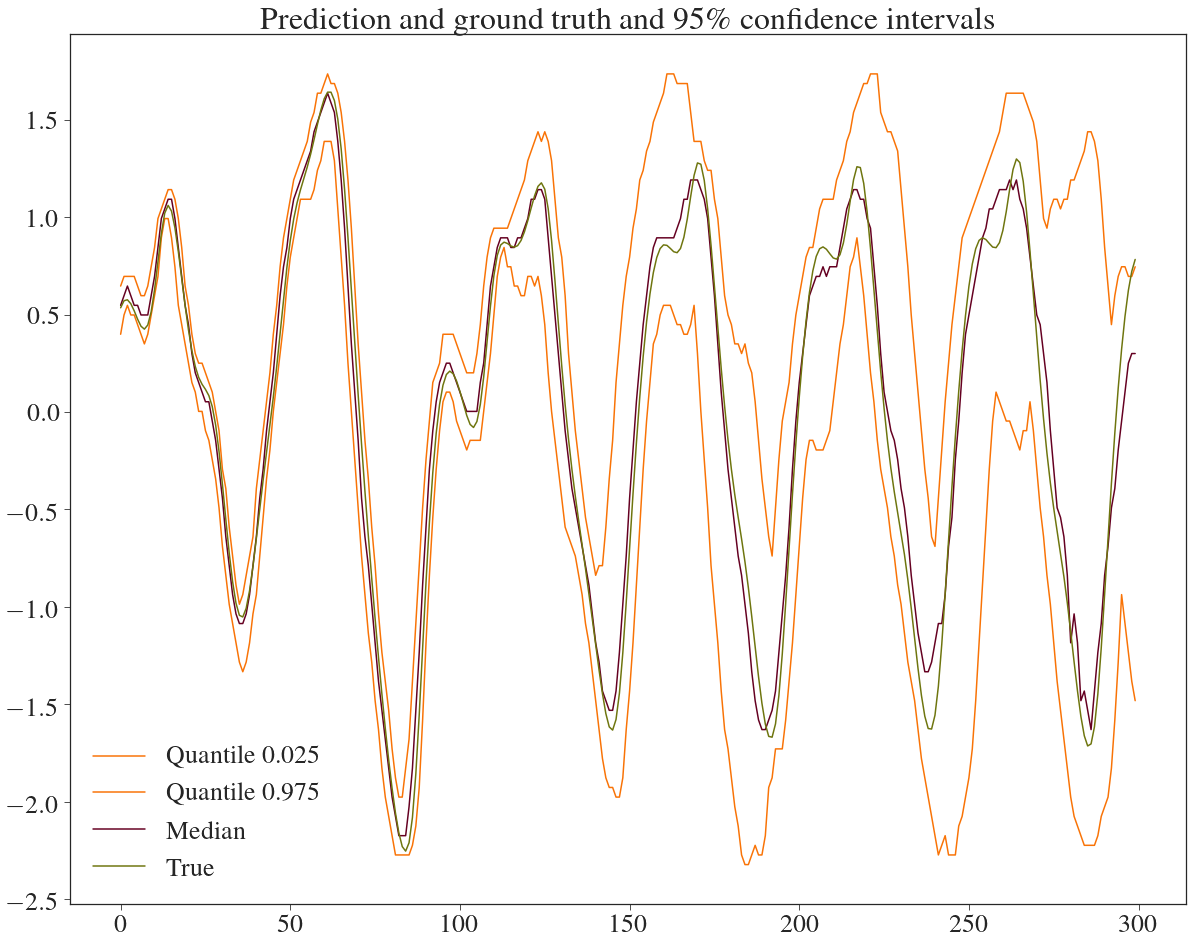

In [29]:
print 'MSE: {} +- {}'.format(*prediction.mse_and_std(continuous_ground_truth))
print 'NLL: {}'.format(prediction.nll(ordinal_ground_truth))

prediction.plot_like(plt)
plt.title('Predictive posterior')
plt.show()

prediction.plot_median_2std(plt, continuous_ground_truth)
plt.title('Prediction and ground truth and 95\% confidence intervals')
plt.show()